In [1]:
import os, sys
import uproot, awkward
import ROOT as rt
import numpy as np
from array import array
# from mpl_toolkits import mplot3d
# import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

Welcome to JupyROOT 6.24/06


In [2]:
#infile = rt.TFile.Open('/data/chocula/fritts/data/k100proc/midasrq/byseries/07220420_0842/')
# series = {
#     '0V' : '07220822_1828',
#     '4V' : '07220826_1219',
#     '21V': '07220826_1536',
#     '65V': '07220826_2007',
#     '84V': '07220827_1153',
#     '84V_1': '07220830_1724'
# }
series = {
    '0V' : '07220822_1828'
    
}
data_path = '/data/chocula/fritts/data/k100proc/midasrq/byseries/'
#infile = uproot.open('/data/chocula/fritts/data/k100proc/midasrq/byseries/07220420_0842/umn_07220420_0842_F0013.root')


In [3]:
series.keys()

dict_keys(['0V'])

In [4]:
rqfiles = {}
for k in series.keys():
    temp = []
    ser = series[k]
    for rq in sorted(os.listdir(data_path+'/'+ser)):
        temp.append(uproot.open(data_path+'/'+ser+'/'+rq)) 
        #print("File added: ",rq)
    rqfiles[k] = temp
    print('%s [%s] data added'%(k,ser))

print('Done!')
    


0V [07220822_1828] data added
Done!


In [5]:
len(rqfiles['0V'])

50

In [55]:
eventTree = ['EventCategory','EventTime','EventNumber']

channels = ['PA','PB','PC','PD','PE','PF','PT']
quantity = ['OFamps','OFamps0' ,'INTall','OFchisq','bs','WKf40','WKr40','WKr20']

# zip1 = ['PTOFamps','PAOFamps','PBOFamps','PCOFamps','PEOFamps','PDOFamps','PEOFamps',
#         'PTINTall','PAINTall','PBINTall','PCINTall','PEINTall','PDINTall','PEINTall',
#        'PTOFchisq','PAOFchisq','PBOFchisq','PCOFchisq','PEOFchisq','PDOFchisq','PEOFchisq',
#        'PAbs','PBbs','PCbs','PDbs,'+PEbs+PFbs]

zip1 = []
for quant in quantity:
    for chan in channels:
        if(chan+quant == 'PTbs'):
            continue
        zip1.append(chan+quant)
print(zip1)

['PAOFamps', 'PBOFamps', 'PCOFamps', 'PDOFamps', 'PEOFamps', 'PFOFamps', 'PTOFamps', 'PAOFamps0', 'PBOFamps0', 'PCOFamps0', 'PDOFamps0', 'PEOFamps0', 'PFOFamps0', 'PTOFamps0', 'PAINTall', 'PBINTall', 'PCINTall', 'PDINTall', 'PEINTall', 'PFINTall', 'PTINTall', 'PAOFchisq', 'PBOFchisq', 'PCOFchisq', 'PDOFchisq', 'PEOFchisq', 'PFOFchisq', 'PTOFchisq', 'PAbs', 'PBbs', 'PCbs', 'PDbs', 'PEbs', 'PFbs', 'PAWKf40', 'PBWKf40', 'PCWKf40', 'PDWKf40', 'PEWKf40', 'PFWKf40', 'PTWKf40', 'PAWKr40', 'PBWKr40', 'PCWKr40', 'PDWKr40', 'PEWKr40', 'PFWKr40', 'PTWKr40', 'PAWKr20', 'PBWKr20', 'PCWKr20', 'PDWKr20', 'PEWKr20', 'PFWKr20', 'PTWKr20']


In [56]:
events = {}
for k in series.keys():
#     if(k != '84V'):
#         continue
    ser = series[k]
    temp_event = {}
    for i in range(len(rqfiles[k])):
        for branch in eventTree:
            if(i == 0):
                temp_event[branch] = rqfiles[k][i]["rqDir/eventTree"][branch].array(library='np')
            else:
                temp_event[branch] = np.concatenate((temp_event[branch],rqfiles[k][i]["rqDir/eventTree"][branch].array(library='np')))
        for branch in zip1:
            if(i == 0):
                temp_event[branch] = rqfiles[k][i]["rqDir/zip1"][branch].array(library='np')
            else:
                temp_event[branch] = np.concatenate((temp_event[branch],rqfiles[k][i]["rqDir/zip1"][branch].array(library='np')))    
    events[k] = temp_event
    print('%s [%s] data appneded'%(k,ser))
    
    

0V [07220822_1828] data appneded


In [8]:
#len(events['65V']['EventCategory'])
len(events['0V']['PTOFamps'])

161790

# Distributions with cut

In [50]:
volt = '0V'
crand = (events[volt]['EventCategory'] == 0)
mask = crand
PTbs = (events[volt]['PAbs']+events[volt]['PBbs']+events[volt]['PCbs']+events[volt]['PDbs']+events[volt]['PEbs']+events[volt]['PFbs'])
#BSel = (events[volt]['PAbs']+events[volt]['PBbs']+events[volt]['PCbs']+events[volt]['PDbs']+events[volt]['PEbs']+events[volt]['PFbs']) -16000
PTchi2 = events[volt]['PTOFchisq']
PTOF = events[volt]['PTOFamps']

cchi2 = (PTchi2 < 2e6)
cbs = (PTbs < 17000)

#for baseline correction
p0 = 3.06
p1 = -6e-4

#0V Am-241 calibration E_kev = alpha * PT_OFAmp + beta * PTOFAmp^2
alpha = 7.738820e+07
beta = 1.653756e+13

In [58]:


h_mbs_total = rt.TH1F('h_mbs_total','meanbaseline for all channels [0V]',1000,15000,25000)
h_mbs_total.GetXaxis().SetTitle('Mean baseline [ADC]')
h_ptchi2 = rt.TH1F('h_ptchi2','PT chi2 [0V]',1000,0,1e7)
h_ptchi2.GetXaxis().SetTitle('chi2')

h_ptof = rt.TH1F('h_ptof','PTOFamps: no cut [0V]',500,0,3e-6)
h_ptof.GetXaxis().SetTitle('amps')
h_ptof_crand = rt.TH1F('h_ptof_crand','PTOFamps: crand [0V]',500,0,3e-6)
h_ptof_crand.GetXaxis().SetTitle('amps')
h_ptof_crand_chi2 = rt.TH1F('h_ptof_crand_chi2','PTOFamps: crand+chi2(<2e6) [0V]',500,0,3e-6)
h_ptof_crand_chi2.GetXaxis().SetTitle('amps')
h_ptof_crand_chi2_bs = rt.TH1F('h_ptof_crand_chi2_bs','PTOFamps: crand+chi2(<2e6)+baseline(<17000ADC) [0V]',500,0,3e-6)
h_ptof_crand_chi2_bs.GetXaxis().SetTitle('amps')

h_mbs_ptchi2_2d = rt.TH2F('h_mbs_ptchi2_2d','meanbaseline vs chi2 [0V]',500,15000,22000,500,0,0.7e7)
h_mbs_ptchi2_2d.GetXaxis().SetTitle('Mean baseline [ADC]')
h_mbs_ptchi2_2d.GetYaxis().SetTitle('chi2 ')

h_bs_PTOF_allCuts_2d = rt.TH2F('h_bs_PTOF_allCuts_2d','mean baseline vs PTOF after cuts [0V]',500,15000,17500,100,0,3e-6) 
h_bs_PTOF_allCuts_2d.GetXaxis().SetTitle('Mean baseline [ADC]')
h_bs_PTOF_allCuts_2d.GetYaxis().SetTitle('PTOF [amps] ')

h_ptof_corr = rt.TH1F('h_ptof_corr','PTOFamps: all cuts + baseline correction [0V]',500,0,3e-6)
h_ptof_corr.GetXaxis().SetTitle('amps')
h_ptof_corr_zoomed = rt.TH1F('h_ptof_corr_zoomed','PTOFamps: all cuts + baseline correction ZOOMED [0V]',500,0,1e-6)
h_ptof_corr_zoomed.GetXaxis().SetTitle('amps')

h_ptof_corr_kev = rt.TH1F('h_ptof_corr_kev','PTOFamps keV: all cuts + baseline correction [0V]',500,0,50)
h_ptof_corr_kev.GetXaxis().SetTitle('amps')

count = 0
for i in tqdm(range(len(mask))):
    h_ptof.Fill(PTOF[i])
    if(crand[i] == 0):
        continue
    h_mbs_total.Fill(PTbs[i])
    h_ptchi2.Fill(PTchi2[i])
    h_mbs_ptchi2_2d.Fill(PTbs[i],PTchi2[i])
    h_ptof_crand.Fill(PTOF[i])
    if(cchi2[i] == 0):
        continue
    h_ptof_crand_chi2.Fill(PTOF[i])
    if(cbs[i] == 0):
        continue
    h_ptof_crand_chi2_bs.Fill(PTOF[i])
    h_bs_PTOF_allCuts_2d.Fill(PTbs[i],PTOF[i])
    pt = PTOF[i]*1e6
    bs_DCcorr = PTbs[i] - 16000
    pt_corr = ((pt)/(1+(p1*bs_DCcorr)/p0))*1e-6
    h_ptof_corr.Fill(pt_corr)
    h_ptof_corr_zoomed.Fill(pt_corr)
    ptcorr_kev = (alpha*pt_corr) + (beta*np.square(pt_corr))
    h_ptof_corr_kev.Fill(ptcorr_kev)
    
    if(((pt_corr*1e6) > 0.22) and ((pt_corr*1e6) < 0.24) and (count < 10)):
        print(events[volt]['EventNumber'][i], ' : ', events[volt]['EventTime'][i], ' : ',pt_corr, ' : ',PTchi2[i]/4096)
        count += 1
print('Done!')

  1%|██▋                                                                                                                                                                                          | 2330/161790 [00:00<00:06, 23298.47it/s]

11095.0  :  1661210939.0  :  2.3369249670155093e-07  :  1.1710854203948735
11107.0  :  1661210939.0  :  2.2702734472982224e-07  :  1.33966311161544
11338.0  :  1661210942.0  :  2.2472353513081908e-07  :  1.538604702486656
11369.0  :  1661210943.0  :  2.3816150060579158e-07  :  35.88752401943318
11404.0  :  1661210944.0  :  2.345309411622338e-07  :  12.21648349887303
11414.0  :  1661210944.0  :  2.386920680437783e-07  :  1.4746078375423926
11433.0  :  1661210944.0  :  2.3929370164865164e-07  :  1.3510575641910594
11488.0  :  1661210945.0  :  2.2814427780075655e-07  :  1.4169172664576088
20022.0  :  1661210946.0  :  2.3710143991308188e-07  :  1.4406881270857415
20147.0  :  1661210948.0  :  2.2091571728049197e-07  :  1.2721765245817542


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161790/161790 [00:06<00:00, 26849.95it/s]


Done!


Warning in <TROOT::Append>: Replacing existing TH1: h_mbs_total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ptchi2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ptof (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ptof_crand (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ptof_crand_chi2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ptof_crand_chi2_bs (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mbs_ptchi2_2d (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_bs_PTOF_allCuts_2d (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ptof_corr (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ptof_corr_zoomed (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ptof_corr_kev (Potential mem

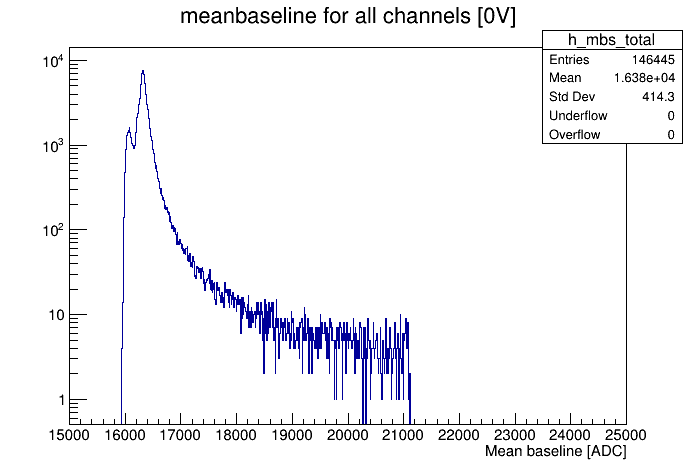

In [28]:
c = rt.TCanvas()
h_mbs_total.Draw()
rt.gPad.SetLogy()
rt.gStyle.SetOptStat(111111)
c.Draw()

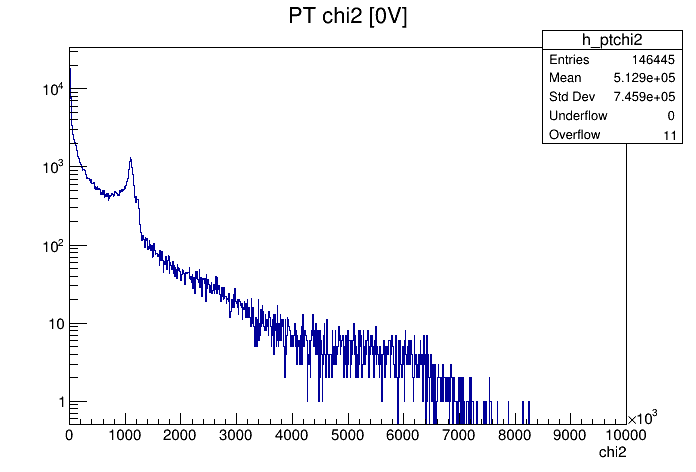

In [29]:
h_ptchi2.Draw()
c.Draw()

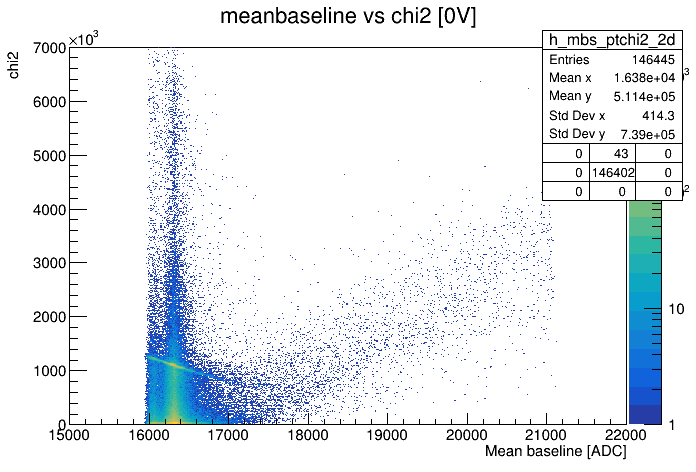

In [30]:
h_mbs_ptchi2_2d.Draw('colz')
rt.gPad.SetLogy(0)
rt.gPad.SetLogz()
c.Draw()

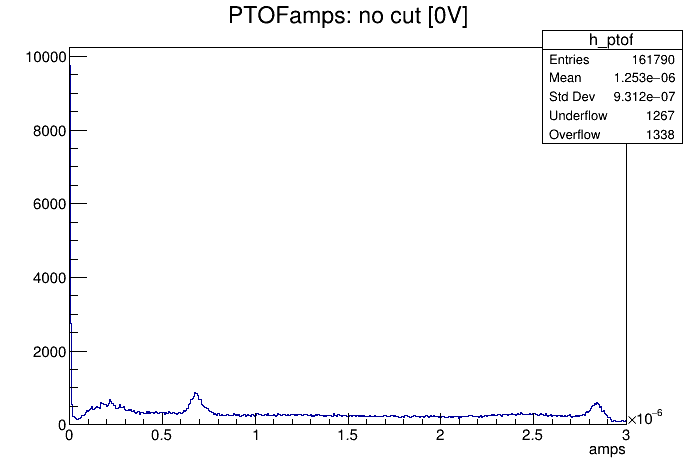

In [41]:
h_ptof.Draw()
c.Draw()

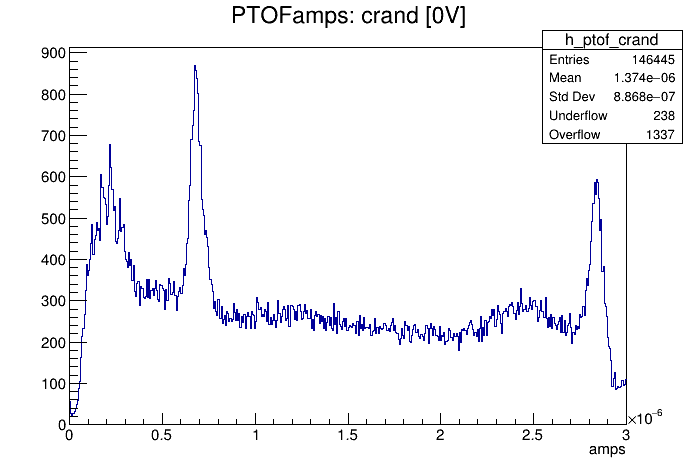

In [42]:
h_ptof_crand.Draw()
c.Draw()

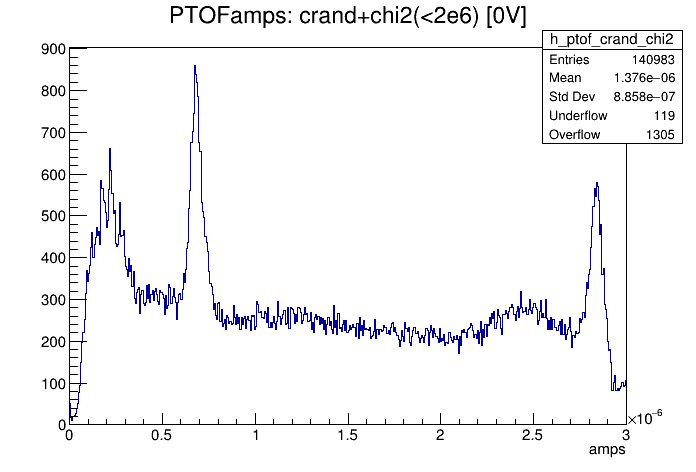

In [43]:
h_ptof_crand_chi2.Draw()
c.Draw()

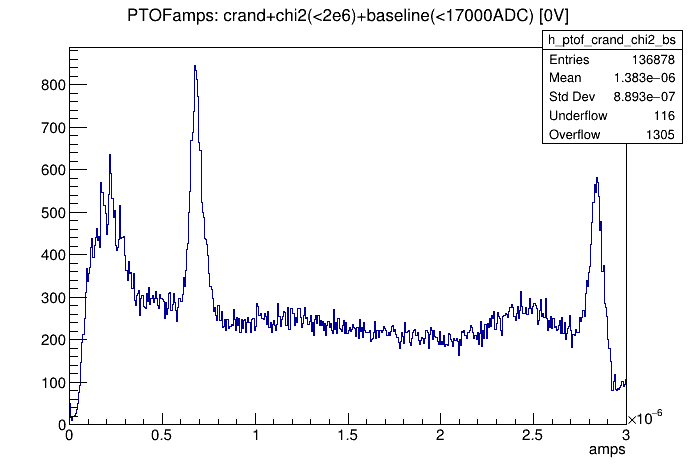

In [46]:
h_ptof_crand_chi2_bs.Draw()
c.Draw()

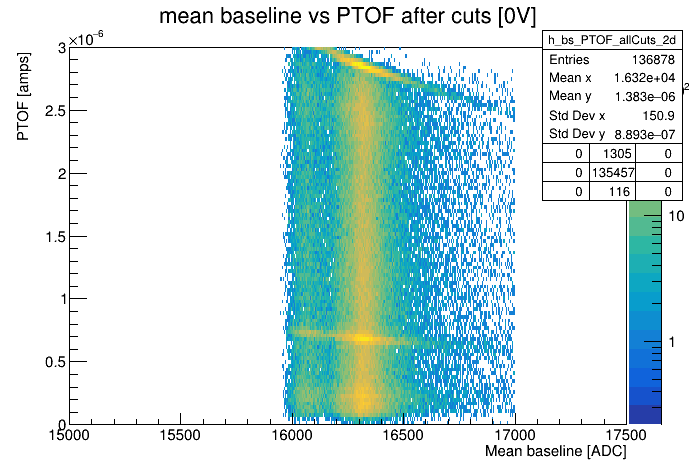

In [36]:
h_bs_PTOF_allCuts_2d.Draw('colz')
c.Draw()

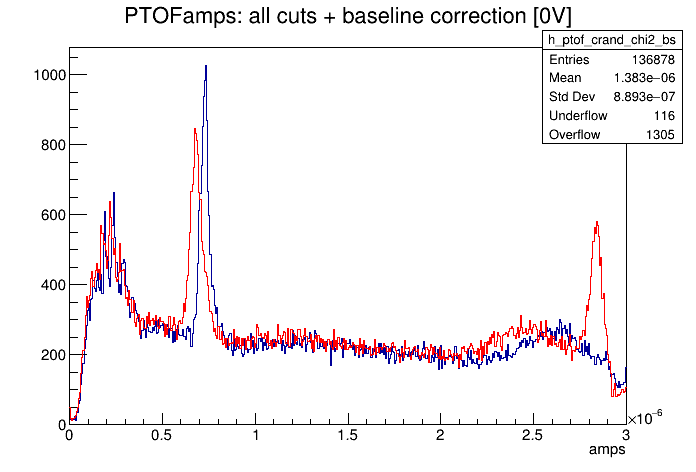

In [47]:
h_ptof_corr.Draw()
h_ptof_crand_chi2_bs.SetLineColor(rt.kRed)
h_ptof_crand_chi2_bs.Draw('same')
c.Draw()

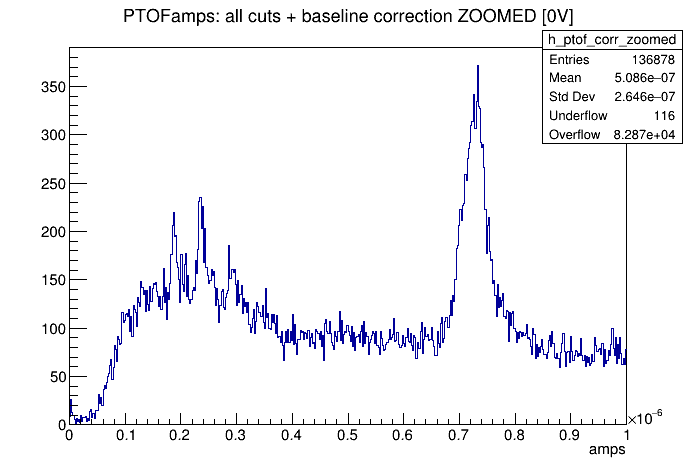

In [49]:
h_ptof_corr_zoomed.Draw()
c.Draw()

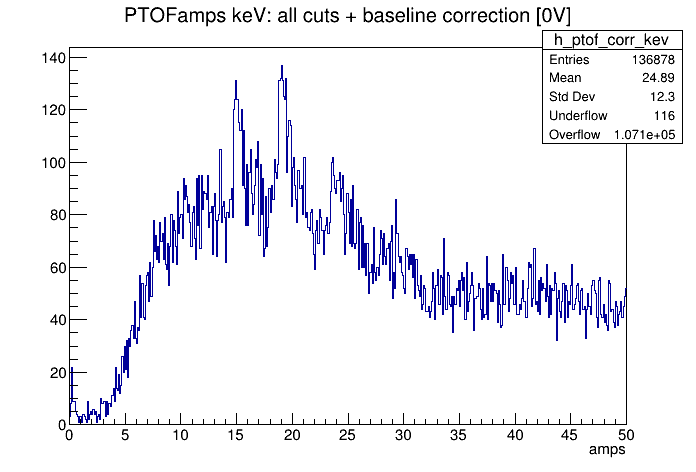

In [52]:
h_ptof_corr_kev.Draw(
                    )
c.Draw()

In [74]:
mask = (events['0V']['EventCategory'] == 0)

In [75]:
len(mask)

161790

In [76]:
len(events['0V']['PTOFamps'][mask])

146445

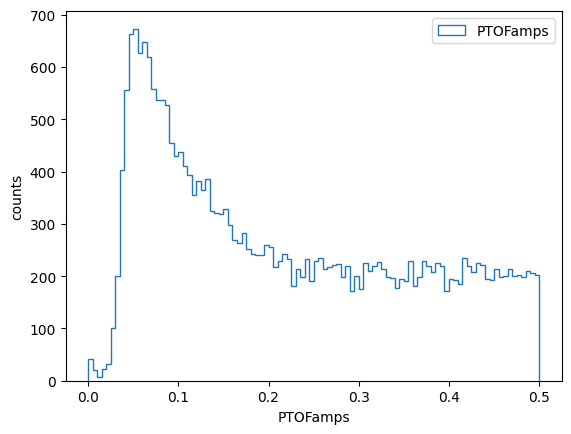

In [87]:
mask = (events['84V']['EventCategory'] == 0)
plt.hist((events['84V']['PTOFamps'][mask])*1e6,bins=100,range=[0,0.5],histtype='step',label="PTOFamps")
plt.xlabel('PTOFamps')
plt.ylabel('counts')
plt.legend(loc='best')

Text(0, 0.5, 'PTOFchisq')

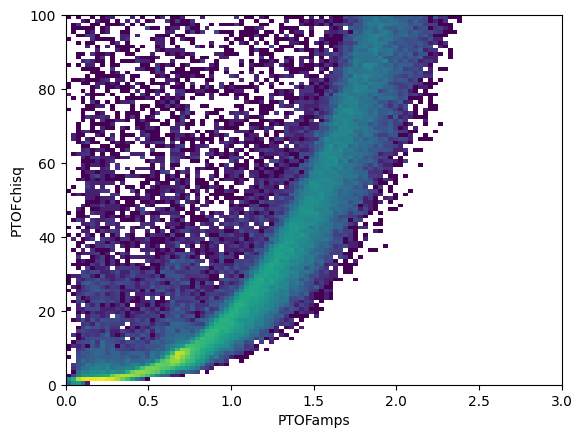

In [112]:
mask = (events['0V']['EventCategory'] == 0)
plt.hist2d((events['0V']['PTOFamps'][mask])*1e6,(events['0V']['PTOFchisq'][mask])/4096,norm=mpl.colors.LogNorm(),bins=[100,100], range=[[0,3],[0,100]])
#plt.hist2d(events['0V']['PTOFchisq'][mask],events['0V']['PTOFamps'][mask],norm=mpl.colors.LogNorm(),bins=[100,1000], range=[[0,5],[3500,5e5]])

#x = events['0V']['PTOFchisq'][mask]
#
plt.xlabel('PTOFamps')
plt.ylabel('PTOFchisq')
#plt.yscale('log')
# plt.xscale('log')


Text(0, 0.5, 'PAbs')

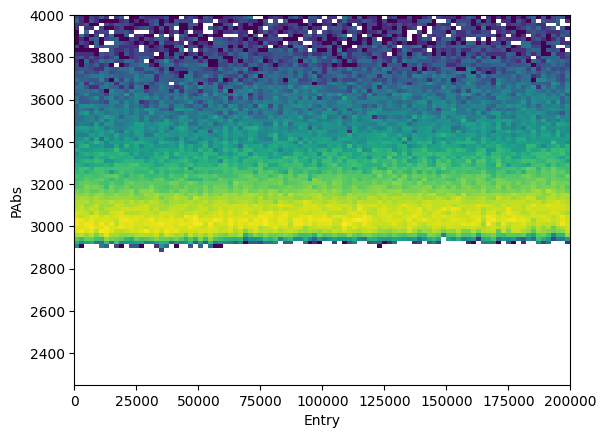

In [138]:
chan = 'PA'
volt = '84V'
mask = (events[volt]['EventCategory'] == 0)
x = range(len(events[volt][chan+'bs'][mask]))
y = events[volt][chan+'bs'][mask]
plt.hist2d(x,y,norm=mpl.colors.LogNorm(),bins=[100,100], range=[[0,200000],[2250,4000]])
#plt.hist2d(x,y,norm=mpl.colors.LogNorm(),bins=[5,100], range=[[200,250],[2250,4000]])
plt.xlabel('Entry')
plt.ylabel(chan+'bs')

Text(0, 0.5, 'PBbs')

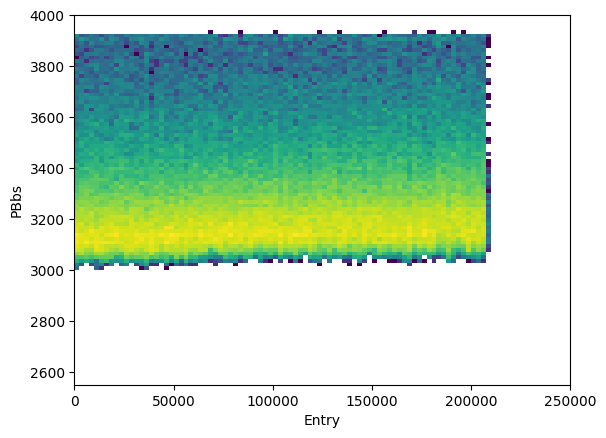

In [140]:
chan = 'PB'
volt = '84V'
mask = (events[volt]['EventCategory'] == 0)
x = range(len(events[volt][chan+'bs'][mask]))
y = events[volt][chan+'bs'][mask]
plt.hist2d(x,y,norm=mpl.colors.LogNorm(),bins=[100,100], range=[[0,250000],[2550,4000]])
#plt.hist2d(x,y,norm=mpl.colors.LogNorm(),bins=[5,100], range=[[200,250],[2250,4000]])
plt.xlabel('Entry')
plt.ylabel(chan+'bs')

Text(0, 0.5, 'PCbs')

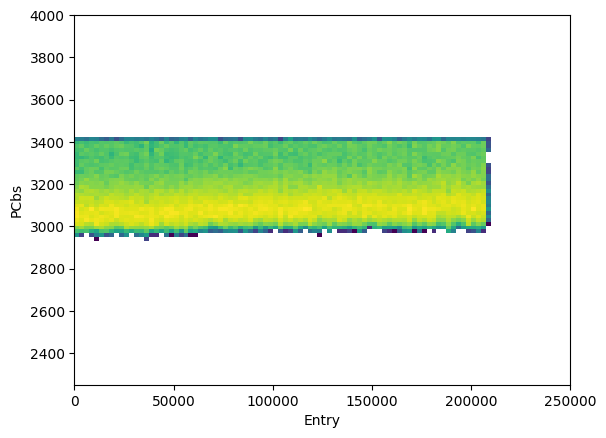

In [141]:
chan = 'PC'
volt = '84V'
mask = (events[volt]['EventCategory'] == 0)
x = range(len(events[volt][chan+'bs'][mask]))
y = events[volt][chan+'bs'][mask]
plt.hist2d(x,y,norm=mpl.colors.LogNorm(),bins=[100,100], range=[[0,250000],[2250,4000]])
#plt.hist2d(x,y,norm=mpl.colors.LogNorm(),bins=[5,100], range=[[200,250],[2250,4000]])
plt.xlabel('Entry')
plt.ylabel(chan+'bs')

Text(0, 0.5, 'PDbs')

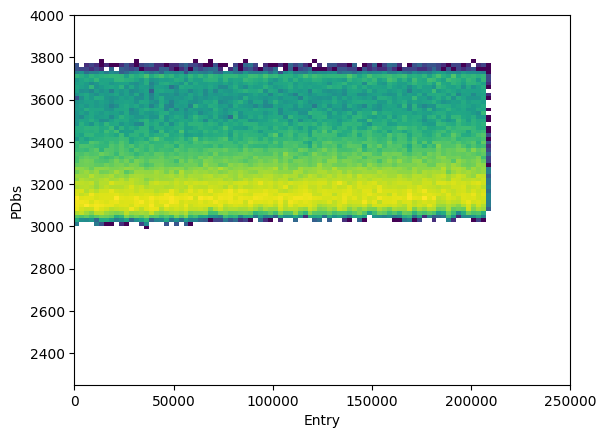

In [142]:
chan = 'PD'
volt = '84V'
mask = (events[volt]['EventCategory'] == 0)
x = range(len(events[volt][chan+'bs'][mask]))
y = events[volt][chan+'bs'][mask]
plt.hist2d(x,y,norm=mpl.colors.LogNorm(),bins=[100,100], range=[[0,250000],[2250,4000]])
#plt.hist2d(x,y,norm=mpl.colors.LogNorm(),bins=[5,100], range=[[200,250],[2250,4000]])
plt.xlabel('Entry')
plt.ylabel(chan+'bs')

Text(0, 0.5, 'PEbs')

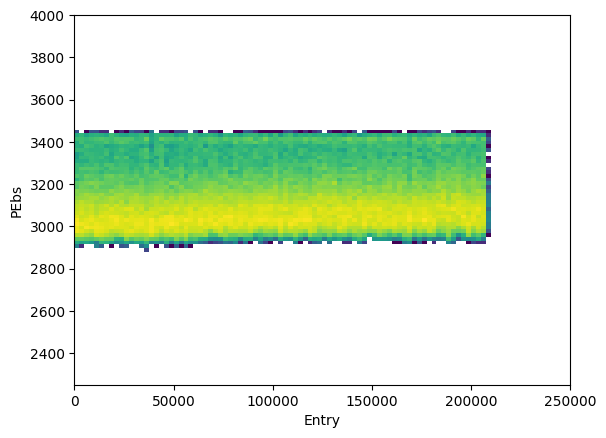

In [143]:
chan = 'PE'
volt = '84V'
mask = (events[volt]['EventCategory'] == 0)
x = range(len(events[volt][chan+'bs'][mask]))
y = events[volt][chan+'bs'][mask]
plt.hist2d(x,y,norm=mpl.colors.LogNorm(),bins=[100,100], range=[[0,250000],[2250,4000]])
#plt.hist2d(x,y,norm=mpl.colors.LogNorm(),bins=[5,100], range=[[200,250],[2250,4000]])
plt.xlabel('Entry')
plt.ylabel(chan+'bs')

Text(0, 0.5, 'PFbs')

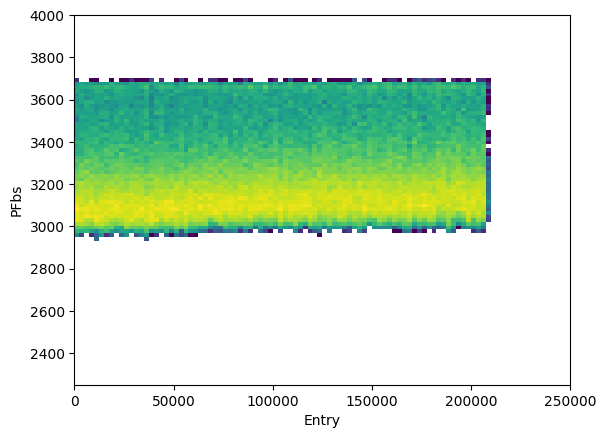

In [144]:
chan = 'PF'
volt = '84V'
mask = (events[volt]['EventCategory'] == 0)
x = range(len(events[volt][chan+'bs'][mask]))
y = events[volt][chan+'bs'][mask]
plt.hist2d(x,y,norm=mpl.colors.LogNorm(),bins=[100,100], range=[[0,250000],[2250,4000]])
#plt.hist2d(x,y,norm=mpl.colors.LogNorm(),bins=[5,100], range=[[200,250],[2250,4000]])
plt.xlabel('Entry')
plt.ylabel(chan+'bs')

Text(0, 0.5, 'PSumbs')

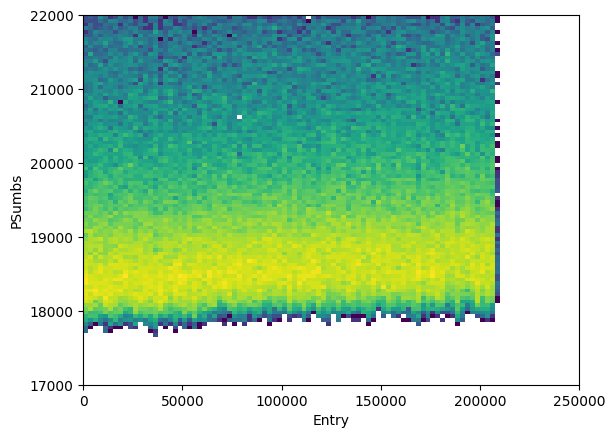

In [150]:
chan = 'PA'
volt = '84V'
mask = (events[volt]['EventCategory'] == 0)
x = range(len(events[volt][chan+'bs'][mask]))
y = events[volt]['PAbs'][mask]+events[volt]['PBbs'][mask]+events[volt]['PCbs'][mask]+events[volt]['PDbs'][mask]+events[volt]['PEbs'][mask]+events[volt]['PFbs'][mask]
plt.hist2d(x,y,norm=mpl.colors.LogNorm(),bins=[100,100], range=[[0,250000],[17000,22000]])
#plt.hist2d(x,y,norm=mpl.colors.LogNorm(),bins=[5,100], range=[[200,250],[2250,4000]])
plt.xlabel('Entry')
plt.ylabel('PSumbs')

Text(0.5, 0, 'BSel')

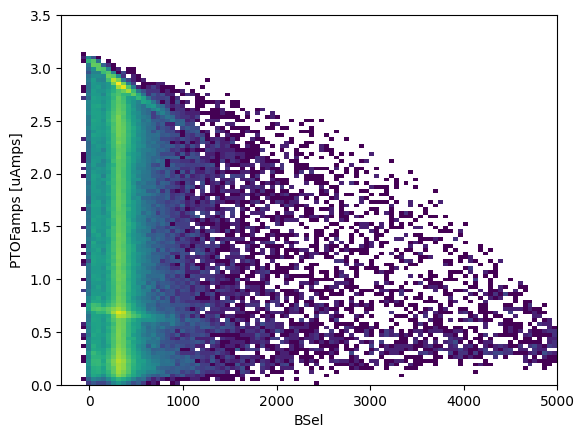

In [185]:
volt = '0V'
mask = mask = (events[volt]['EventCategory'] == 0)
BSel = (events[volt]['PAbs']+events[volt]['PBbs']+events[volt]['PCbs']+events[volt]['PDbs']+events[volt]['PEbs']+events[volt]['PFbs']) -16000
chan = 'PT'


#plt.hist2d((events[volt][chan+'OFamps'][mask])*1e6,BSel[mask],bins=[100,100],range=[[0,3.5],[-300,5000]],norm=mpl.colors.LogNorm())

plt.hist2d(BSel[mask],(events[volt][chan+'OFamps'][mask])*1e6,bins=[100,100],range=[[-300,5000],[0,3.5]],norm=mpl.colors.LogNorm())

plt.ylabel('PTOFamps [uAmps]')
plt.xlabel('BSel')

In [206]:
h_bsel_PTOFL = rt.TH2F('h_bsel_PTOFL','h_bsel_PTOFL',100,-300,1000,350,0,3.5)
h_bsel_PTOFL.GetXaxis().SetTitle('Mean Baseline')
h_bsel_PTOFL.GetYaxis().SetTitle('PTOFL (uAmps)')
for i in range(len(mask)):
    if(mask[i] == 0):
        continue
    if(BSel[i] > 1200):
        continue
    h_bsel_PTOFL.Fill(BSel[i],(events[volt][chan+'OFamps'][i])*1e6)
print('Done!')

Done!


Warning in <TROOT::Append>: Replacing existing TH1: h_bsel_PTOFL (Potential memory leak).


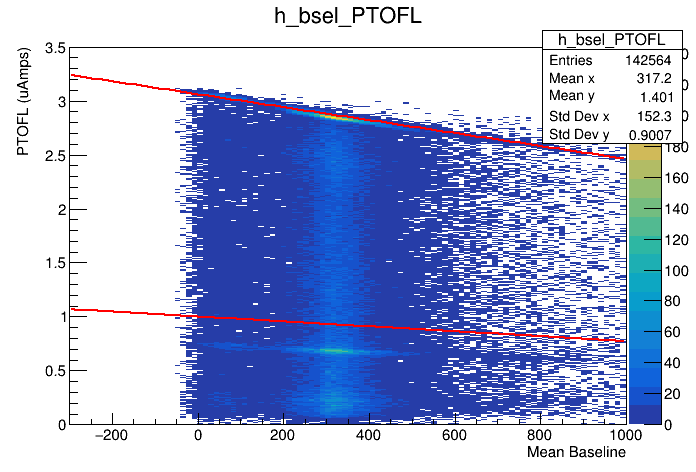

In [215]:
line = rt.TF1('line','[0]+[1]*x',-300,5000)
line.SetParameters(3.06,-6e-4)
line2 = rt.TF1('line2','[0]+[1]*x',-300,5000)
line2.SetParameters(1,(-7e-4)/3.07)
h_bsel_PTOFL.Draw('colz')
line.Draw('same')
line2.Draw('same')
c.Draw()

In [229]:
h_bsel_PTOFL_corr = rt.TH2F('h_bsel_PTOFL_corr','h_bsel_PTOFL_corr',100,-300,1000,350,0,3.5)
h_bsel_PTOFL_corr.GetXaxis().SetTitle('Mean Baseline')
h_bsel_PTOFL_corr.GetYaxis().SetTitle('PTOFL (uAmps)')
p0 = 3.06
p1 = -6e-4
h_ptcorr = rt.TH1F('h_ptcorr','h_ptcorr',200,0,1)
h_ptcorr.GetXaxis().SetTitle('PTOFL (uAmps)')
for i in range(len(mask)):
    if(mask[i] == 0):
        continue
    if(BSel[i] > 1200):
        continue
    pt = (events[volt][chan+'OFamps'][i])*1e6
    pt_corr = (pt)/(1+(p1*BSel[i])/p0)
    h_bsel_PTOFL_corr.Fill(BSel[i],pt_corr)
    h_ptcorr.Fill(pt_corr)
print('Done!')

Done!


Warning in <TROOT::Append>: Replacing existing TH1: h_bsel_PTOFL_corr (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_ptcorr (Potential memory leak).


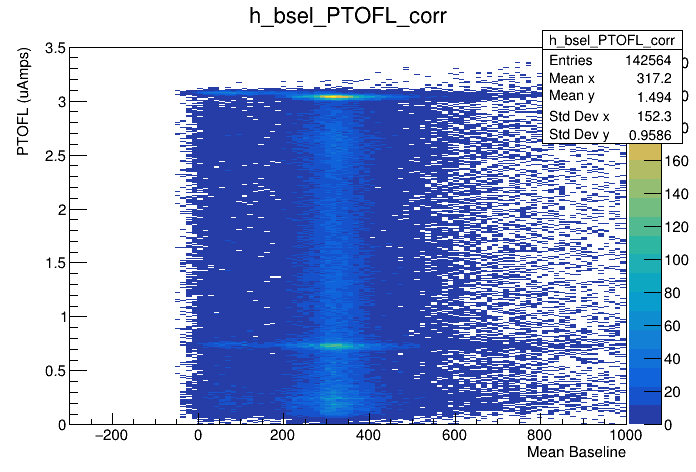

In [230]:
h_bsel_PTOFL_corr.Draw('colz')
c.Draw()

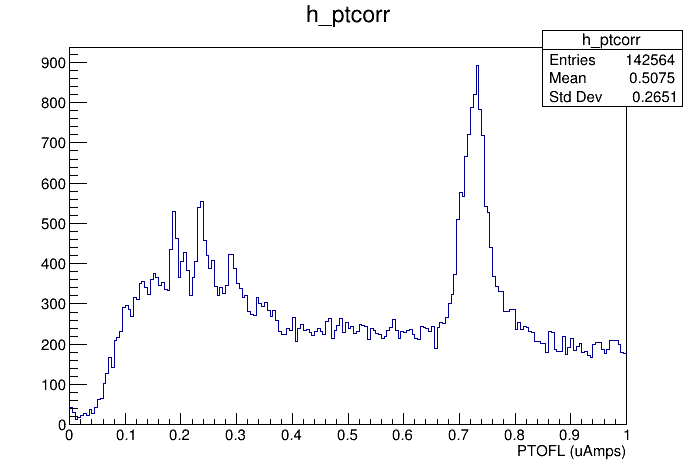

In [231]:
h_ptcorr.Draw()
c.Draw()

In [232]:
outputfile = rt.TFile.Open('output.root','recreate')
outputfile.cd()
h_ptcorr.Write()
outputfile.Write()
outputfile.Close()

In [181]:
np.square(events[volt]['PTOFamps'][0:10])

array([1.32990931e-17, 5.55499550e-18, 1.03776528e-17, 1.84217276e-17,
       1.15032694e-17, 1.08280038e-18, 6.27666998e-19, 3.16101993e-17,
       1.19508833e-17, 1.54305827e-17])

In [182]:
a = 7.738820e07
b = 1.653756e+13

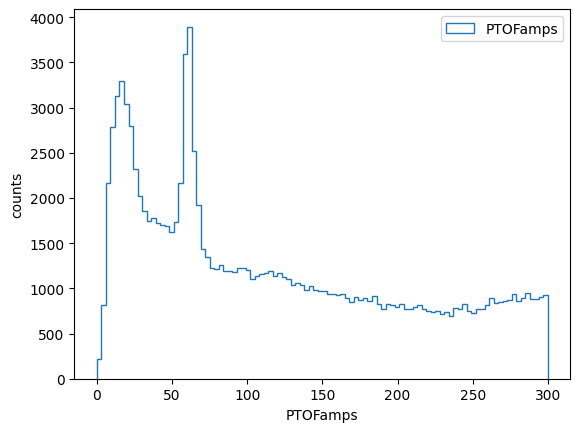

In [183]:
volt = '0V'
mask = (events[volt]['EventCategory'] == 0)
pt_kev = (a*events[volt]['PTOFamps']) + (b*np.square(events[volt]['PTOFamps']))
#plt.hist((events[volt]['PTOFamps'][mask])*1e6,bins=100,range=[0,3.5],histtype='step',label="PTOFamps")
plt.hist(pt_kev[mask],bins=100,range=[0,300],histtype='step',label="PTOFamps")

plt.xlabel('PTOFamps')
plt.ylabel('counts')
plt.legend(loc='best')

(array([[0., 5., 8., ..., 0., 0., 0.],
        [0., 0., 3., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([     0.,   2500.,   5000.,   7500.,  10000.,  12500.,  15000.,
         17500.,  20000.,  22500.,  25000.,  27500.,  30000.,  32500.,
         35000.,  37500.,  40000.,  42500.,  45000.,  47500.,  50000.,
         52500.,  55000.,  57500.,  60000.,  62500.,  65000.,  67500.,
         70000.,  72500.,  75000.,  77500.,  80000.,  82500.,  85000.,
         87500.,  90000.,  92500.,  95000.,  97500., 100000., 102500.,
        105000., 107500., 110000., 112500., 115000., 117500., 120000.,
        122500., 125000., 127500., 130000., 132500., 135000., 137500.,
        140000., 142500., 145000., 147500., 150000., 152500., 155000.,
        157500., 160000., 162500., 165000., 167500., 170000., 172500.,
        175000., 177500., 180000., 182500

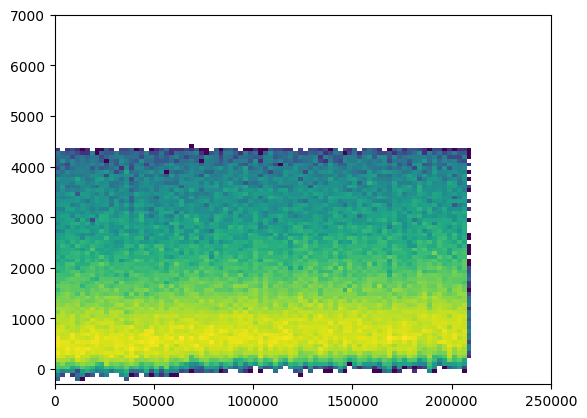

In [165]:
x = range(len(BSel[mask]))
y = BSel[mask]
#plt.hist2d(x[mask],y[mask],bins=[100,100], range=[[0,250000],[-300,7000]])
plt.hist2d(x,y,norm=mpl.colors.LogNorm(),bins=[100,100], range=[[0,250000],[-300,7000]])

In [96]:
#h_chi2_PTOF = rt.TH2F('h_chi2_PTOF','h_chi2_PTOF',1000,3500,5e5,100,0,5)
h_PTOF_chi2 = rt.TH2F('h_PTOF_chi2','h_PTOF_chi2',100,0,3,1000,3500,10e5)
h_PTOF_chi2.GetXaxis().SetTitle('PTOFamps [uAmps]')
h_PTOF_chi2.GetYaxis().SetTitle('Chi2')
h_PTOF = rt.TH1F('h_PTOF','h_PTOF',100,0,3)
h_PTOF.GetXaxis().SetTitle('PTOFamps [uAmps]')
mask = (events['0V']['EventCategory'] == 0)
for i in range(len(mask)):
    
    if(~mask[i]):
        continue
    #h_chi2_PTOF.Fill(events['0V']['PTOFchisq'][i],events['0V']['PTOFamps'][i]*1e6)
    h_PTOF_chi2.Fill(events['0V']['PTOFamps'][i]*1e6,events['0V']['PTOFchisq'][i])
    h_PTOF.Fill(events['0V']['PTOFamps'][i]*1e6)
print('Done!')

Done!


Warning in <TROOT::Append>: Replacing existing TH1: h_PTOF_chi2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_PTOF (Potential memory leak).


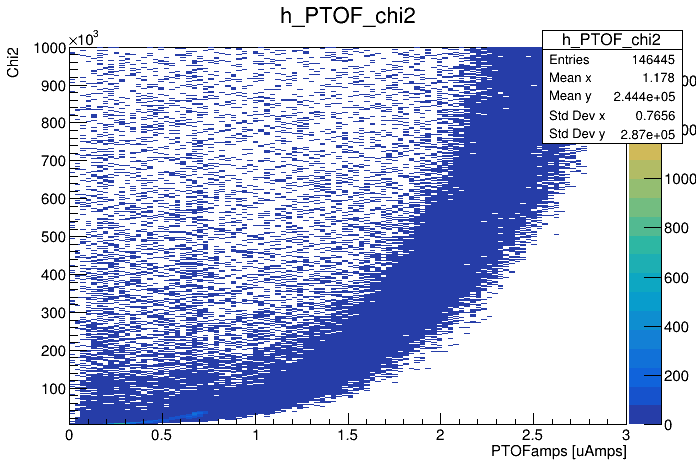

In [97]:
c = rt.TCanvas()
h_PTOF_chi2.Draw('colz')
c.Draw()

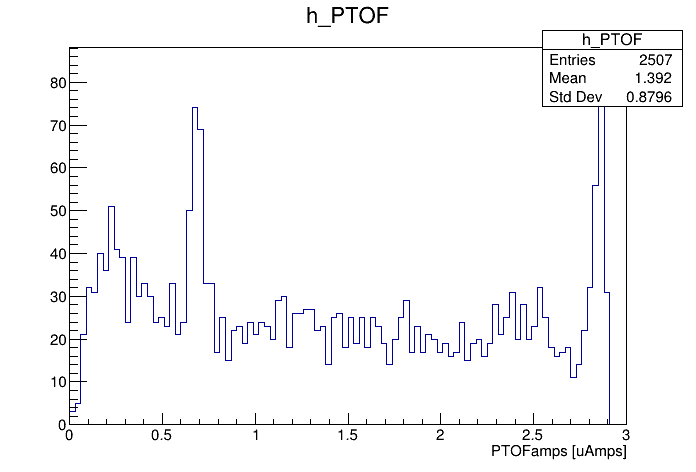

In [47]:
h_PTOF.Draw()
c.Draw()

In [71]:
#h_chi2_PTOF = rt.TH2F('h_chi2_PTOF','h_chi2_PTOF',1000,3500,5e5,100,0,5)
h_PTOF_chi2_84V = rt.TH2F('h_PTOF_chi2_84V','h_PTOF_chi2_84V',100,0,3,1000,3500,10e5)
h_PTOF_chi2_84V.GetXaxis().SetTitle('PTOFamps [uAmps]')
h_PTOF_chi2_84V.GetYaxis().SetTitle('Chi2')

h_PTOF_84V = rt.TH1F('h_PTOF_84V','h_PTOF_84V',100,0,3)
h_PTOF_84V.GetXaxis().SetTitle('PTOFamps [uAmps]')
volt = '84V'
chan = 'PT'
mask = (events[volt]['EventCategory'] == 0)
for i in range(len(mask)):    
    if(~mask[i]):
        continue
    #h_chi2_PTOF.Fill(events['0V']['PTOFchisq'][i],events['0V']['PTOFamps'][i]*1e6)
    h_PTOF_chi2_84V.Fill(events[volt][chan+'OFamps'][i]*1e6,events[volt][chan+'OFchisq'][i])
    h_PTOF_84V.Fill(events[volt][chan+'OFamps'][i]*1e6)
print('Done!')

Done!


Warning in <TROOT::Append>: Replacing existing TH1: h_PTOF_chi2_84V (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_PTOF_84V (Potential memory leak).


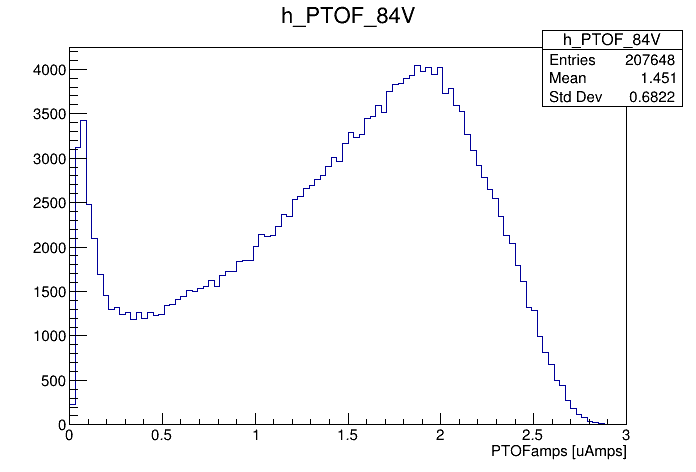

In [72]:
h_PTOF_84V.Draw()
c.Draw()

In [54]:
#h_chi2_PTOF = rt.TH2F('h_chi2_PTOF','h_chi2_PTOF',1000,3500,5e5,100,0,5)
h_PTOF_chi2_84V = rt.TH2F('h_PTOF_chi2_84V','h_PTOF_chi2_84V',100,0,3,1000,3500,10e5)
h_PTOF_chi2_84V.GetXaxis().SetTitle('PTOFamps [uAmps]')
h_PTOF_chi2_84V.GetYaxis().SetTitle('Chi2')

h_PTOF_84V = rt.TH1F('h_PTOF_84V','h_PTOF_84V',100,0,3)
h_PTOF_84V.GetXaxis().SetTitle('PTOFamps [uAmps]')
volt = '84V_1'
chan = 'PT'
mask = (events[volt]['EventCategory'] == 0)
for i in range(len(mask)):    
    if(~mask[i]):
        continue
    #h_chi2_PTOF.Fill(events['0V']['PTOFchisq'][i],events['0V']['PTOFamps'][i]*1e6)
    h_PTOF_chi2_84V.Fill(events[volt][chan+'OFamps'][i]*1e6,events[volt][chan+'OFchisq'][i])
    h_PTOF_84V.Fill(events[volt][chan+'OFamps'][i]*1e6)
print('Done!')

Done!


Warning in <TROOT::Append>: Replacing existing TH1: h_PTOF_chi2_84V (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_PTOF_84V (Potential memory leak).


In [59]:
len(events['84V']['PAOFamps'])

805

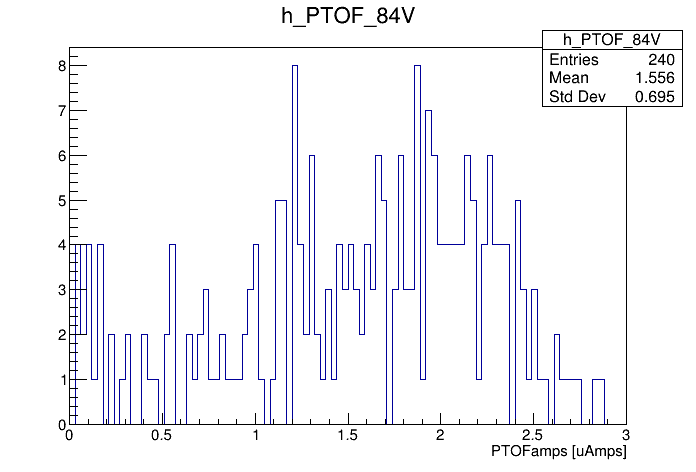

In [55]:
h_PTOF_84V.Draw()
c.Draw()